# Data exploration

In [1]:
import pandas as pd
from data_utils import load_movie_data
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from data_cleaning import clean_dataset

DATA_DIR = '../../all_data_run_2511/data'
df = load_movie_data(DATA_DIR, verbose=False)
df = clean_dataset(
    df, wrong_classes_save_path=os.path.join(DATA_DIR, 'wrong_wikidata_classes.json')
)

Original dataset size: 141119
After filtering movies without plot: 99336
After filtering non-movies: 98513
After filtering movies with plot length > 14000 chars: 98494


In [10]:
def plot_bar_chart_of_column(
    df: pd.DataFrame, column_name: str, top_n: int = 20
):
    # compute top values as percentages
    value_counts = df[column_name].value_counts().head(top_n)
    value_counts_pct = value_counts / value_counts.sum() * 100  # percent 0..100

    plt.figure(figsize=(10, 6))
    ax = value_counts_pct.plot(kind='bar', color='C0', edgecolor='k')
    plt.title(f'Top {top_n} most common values in column \"{column_name}\" (percent)')
    plt.xlabel(column_name)
    plt.ylabel('Percent of rows')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=100))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_histogram_of_column(
    df: pd.DataFrame, column_name: str, bin_size: int = 10
):
    plt.figure(figsize=(8, 5))
    max_value = int(df[column_name].max())
    bins = range(0, max_value + bin_size, bin_size)
    plt.hist(df[column_name], bins=bins, color='C0', edgecolor='k')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Number of movies')
    plt.tight_layout()
    plt.show()

def plot_cumulative_distribution(
    df: pd.DataFrame, column_name: str
):
    sorted_values = df[column_name].sort_values().reset_index(drop=True)
    cumulative = sorted_values.cumsum()
    cumulative_pct = cumulative / cumulative.iloc[-1] * 100  # percent 0..100

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_values, cumulative_pct, linestyle='-')
    plt.title(f'Cumulative distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Cumulative percent of total')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

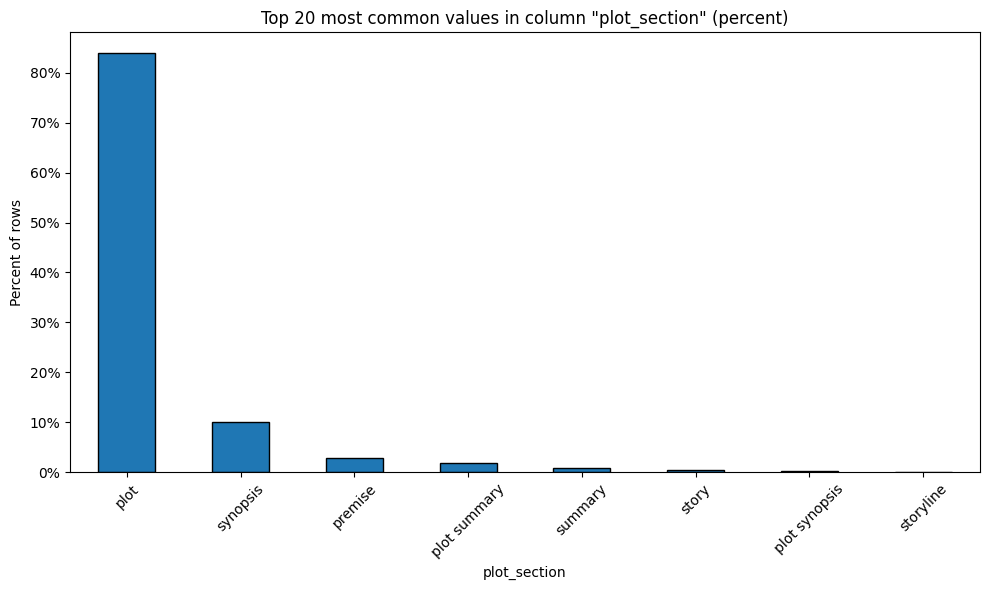

plot_section
plot             82600
synopsis          9971
premise           2740
plot summary      1757
summary            767
story              375
plot synopsis      208
storyline           76
Name: count, dtype: int64


In [3]:
plot_bar_chart_of_column(df, 'plot_section')
print(df["plot_section"].value_counts())

In [4]:
pd.set_option('display.width', 300)
df[df["plot_section"] == "synopsis"]["movie_id"][-20:-10]

98423    Q129485961
98425    Q129675920
98440    Q130240841
98443    Q131195878
98445    Q126617484
98448    Q129255850
98450    Q130259789
98452    Q130304875
98456    Q130362802
98458    Q130385345
Name: movie_id, dtype: object

## Plot length

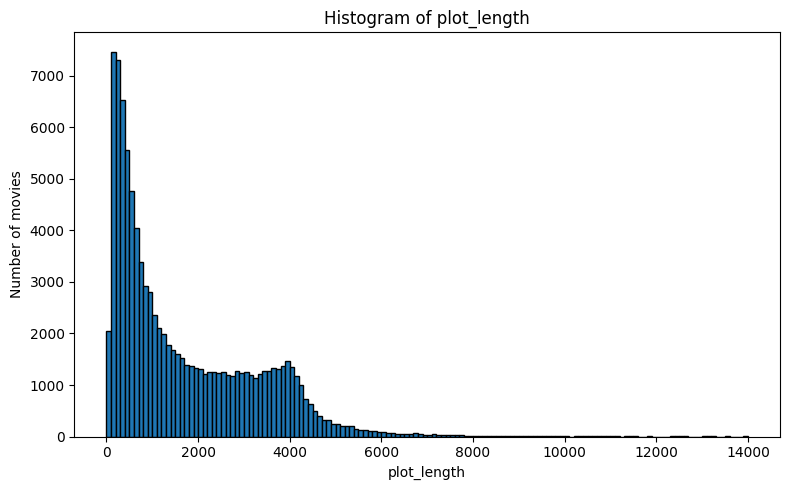

In [6]:
df["plot_length"] = df["plot"].apply(lambda x: len(x.strip()) if isinstance(x, str) else 0)
(df["plot_length"] > 14000).sum()
plot_histogram_of_column(df, 'plot_length', bin_size=100)

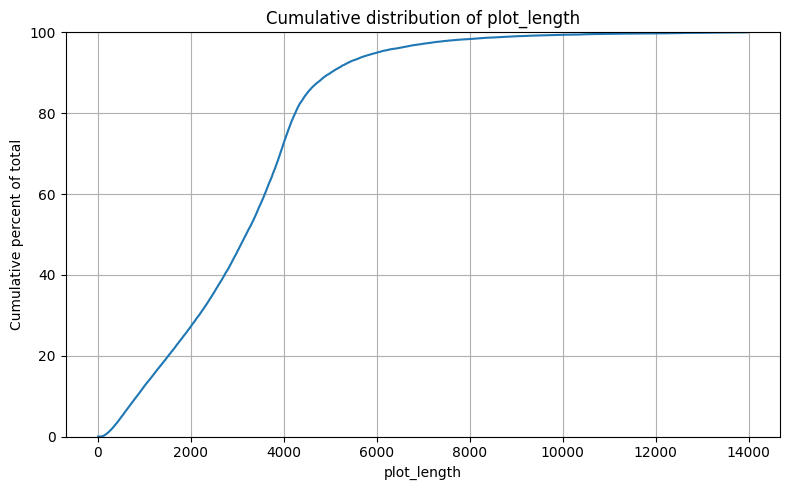

In [11]:
plot_cumulative_distribution(df, 'plot_length')

In [25]:
def get_list_feature_distribution(df: pd.DataFrame, column_name: str) -> pd.Series:
    rows_with_different_values = {}
    for _, row in df.iterrows():
        row_values = row.get(column_name, "")
        if not isinstance(row_values, str) or not row_values.strip():
            continue
        values_list = [
            cls.strip() for cls in row_values.split(',') if cls.strip()
        ]
        rows_with_different_values[len(values_list)] = rows_with_different_values.get(len(values_list), 0) + 1
    total = sum(rows_with_different_values.values())
    for k in rows_with_different_values.keys():
        rows_with_different_values[k] /= total
    return pd.Series(rows_with_different_values).sort_index()

def plot_list_feature_distribution(
    df: pd.DataFrame, column_name: str
):
    distribution = get_list_feature_distribution(df, column_name)

    plt.figure(figsize=(8, 5))
    plt.bar(distribution.index, distribution.values, color='C0', edgecolor='k')
    plt.title(f'Distribution of number of {column_name} per movie')
    plt.xlabel(f'Number of {column_name} per movie')
    plt.ylabel('Percentage of movies')
    plt.xticks(distribution.index)
    plt.tight_layout()
    plt.show()

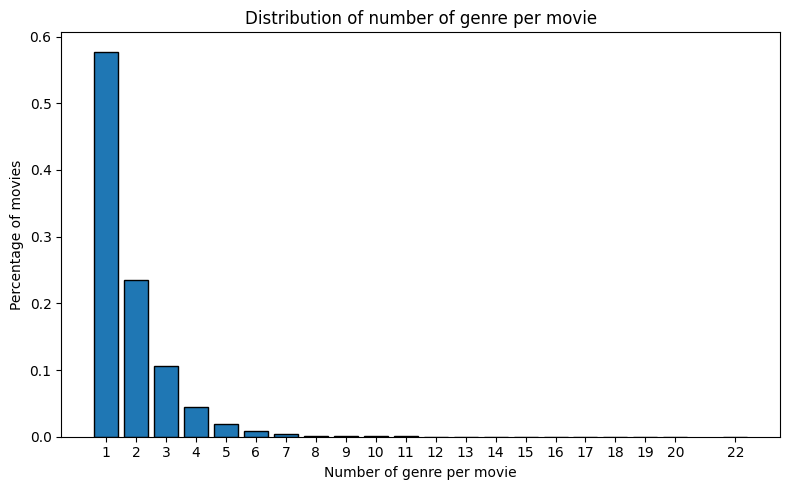

In [26]:
plot_list_feature_distribution(df, 'genre')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98494 entries, 0 to 98493
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       98494 non-null  object 
 1   country                        97573 non-null  object 
 2   imdb_id                        97030 non-null  object 
 3   duration                       60861 non-null  float64
 4   duration_all                   60861 non-null  object 
 5   actors_id                      80068 non-null  object 
 6   actors                         80068 non-null  object 
 7   directors_id                   92282 non-null  object 
 8   directors                      92282 non-null  object 
 9   genre_id                       86172 non-null  object 
 10  genre                          86172 non-null  object 
 11  release_date                   98494 non-null  object 
 12  wikidata_class                 98494 non-null 

## Durations

In [14]:
get_list_feature_distribution(df, "duration_all")

1    77570
2     1837
3       69
4       19
5        3
7        1
dtype: int64

1    95697.502539
2     2663.793299
3      100.337293
4       25.893495
5        4.855030
7        1.618343
dtype: float64


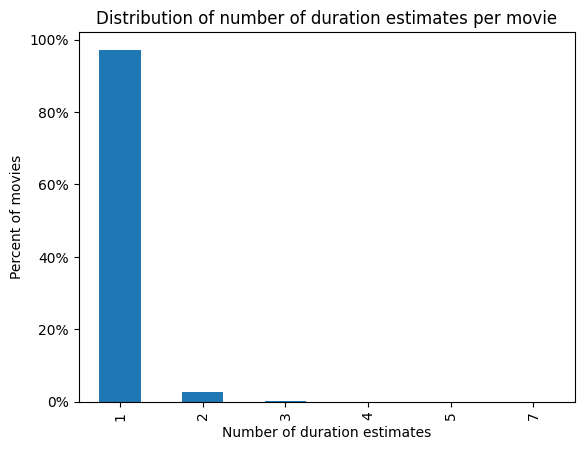

In [ ]:
import matplotlib.ticker as mtick

s = get_list_feature_distribution(df, "duration_all")
print(s)
s_frac = s / s.sum()  # fractions 0..1
ax = s_frac.plot(kind='bar', title='Distribution of number of duration estimates per movie')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlabel('Number of duration estimates')
plt.ylabel('Percent of movies')
plt.show()

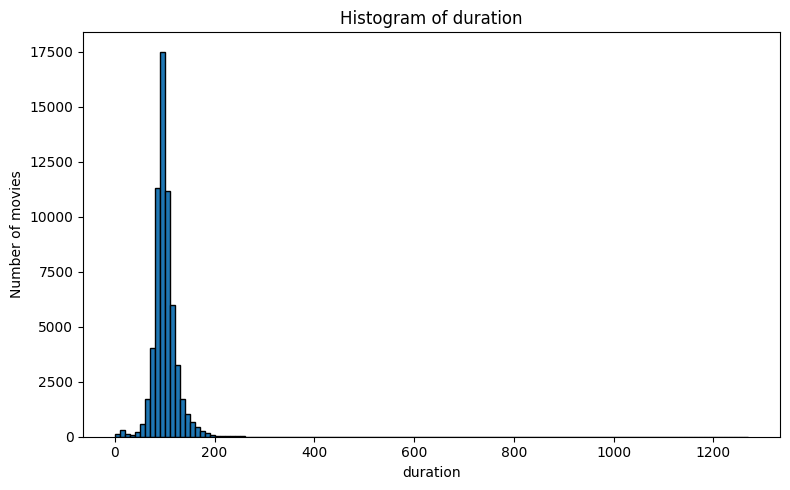

In [30]:
plot_histogram_of_column(df, "duration", bin_size=10)

In [8]:
df[df["duration"].max() == df["duration"]]
# Longest film ever made

,movie_id,country,imdb_id,duration,duration_all,actors_id,actors,directors_id,directors,genre_id,...,box_office,box_office_currency,box_office_worldwide,box_office_worldwide_currency,popularity,vote_average,vote_count,tmdb_id,plot,year
107463,Q23044707,Sweden,tt8273150,51420.0,51420,NaN,NaN,"Q108064180,Q108064181","Erika Magnusson, Daniel Andersson","Q93204,Q790192",...,NaN,NaN,NaN,NaN,1.4902,7.6,5,421017,"Logistics, or Logistics Art Project, is a 2012...",2012


In [15]:
UNUSUAl_DURATION = 300  # 5 hours
(df["duration"] > UNUSUAl_DURATION).sum()

np.int64(111)

206 movies longer than 4 hours

(array([8.9000e+01, 2.6100e+02, 3.1000e+02, 1.9200e+02, 1.7300e+02,
        1.3500e+02, 1.1500e+02, 2.0600e+02, 4.0100e+02, 7.8800e+02,
        1.4030e+03, 1.8430e+03, 3.1960e+03, 5.8800e+03, 1.0186e+04,
        1.5778e+04, 1.1400e+04, 8.2660e+03, 5.6410e+03, 3.5880e+03,
        2.8880e+03, 1.6250e+03, 1.1700e+03, 9.3400e+02, 5.8300e+02,
        5.4200e+02, 3.6900e+02, 3.1400e+02, 2.4200e+02, 1.6500e+02,
        2.1200e+02, 9.6000e+01, 6.7000e+01, 5.9000e+01, 3.7000e+01,
        2.3000e+01, 2.1000e+01, 2.4000e+01, 1.3000e+01, 2.3000e+01,
        4.6000e+01, 9.0000e+00, 1.2000e+01, 8.0000e+00, 9.0000e+00,
        1.6000e+01, 8.0000e+00, 3.0000e+00, 6.0000e+00, 1.3000e+01]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
        198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.,
        264., 270., 27

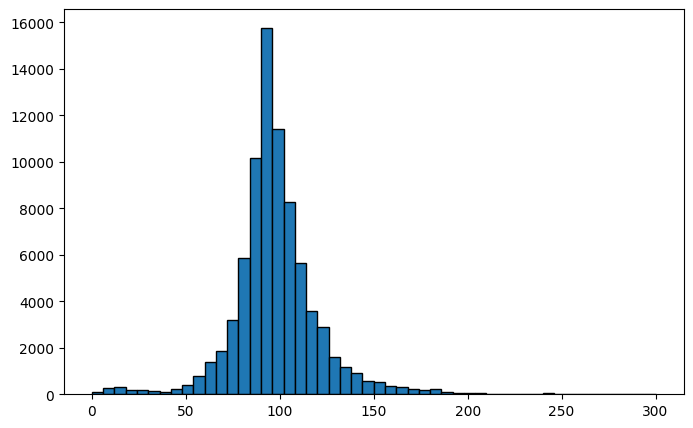

In [16]:
df_normal = df[df["duration"] <= UNUSUAl_DURATION].copy()

fig, ax_hist = plt.subplots(figsize=(8, 5))
# use 10-minute bins; fallback to 50 bins if max is very large
max_d = int(df_normal["duration"].max())
ax_hist.hist(df_normal["duration"], bins=50, color='C0', edgecolor='k')